## Import standard libraries

In [1]:
import torch
import torch.nn as nn  # we'll use this a lot going forward!
import torch.nn.functional as F

import numpy as np
import warnings

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import pyplot as plt, rc

# Import json library and create function to format dictionaries.
import json
format_json = lambda x: json.dumps(x, indent=4)

# Import pandas and set pandas DataFrame visualization parameters
from IPython.display import display
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Set rendering parameters to use TeX font if not working on Juno app.
from pathlib import Path
import os
if not '/private/var/' in os.getcwd():
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)
    
# Get current working directory path for the tool parent folder and print it.
parent_folder = 'scalib'
cwd = str(Path(os.getcwd()[:os.getcwd().index(parent_folder)+len(parent_folder)]))
print('Parent working directory: %s' % cwd)


# Import custom libraries from local folder.
import sys
sys.path.append("..")

from scalib import utils, eda, cfg, sdg
from scalib import rnn

Parent working directory: /Users/jjrr/Documents/SCA-Project/Tool


## Data preparation

In [2]:
# Get inputs and outputs in the right shape to feed the LSTM model
output_features = cfg.get_features(**{'compulsory':True, 'independent': True, 
                                      'cluster':['conjunction',
                                                 'relative_state']})

output_features.remove('c_object_type')
input_features  = output_features + cfg.get_features(**{'cluster':'covariance'}) 

# Get input and output size from the list of features
input_size = len(input_features)
output_size = len(output_features)

print(f'Forecasting model inputs ({input_size}):\n'
      f'{utils.tabular_list(input_features)}'
      f'\nForecasting model outputs ({output_size}):\n'
      f'{utils.tabular_list(output_features)}')

Forecasting model inputs (50):
time_to_tca                	t_ctdot_rdot               	c_cndot_t                  	
time_to_cdm                	t_cndot_r                  	c_cndot_n                  	
relative_velocity_r        	t_cndot_t                  	c_cndot_rdot               	
relative_velocity_t        	t_cndot_n                  	c_cndot_tdot               	
relative_velocity_n        	t_cndot_rdot               	t_sigma_r                  	
relative_position_r        	t_cndot_tdot               	c_sigma_r                  	
relative_position_t        	c_ct_r                     	t_sigma_t                  	
relative_position_n        	c_cn_r                     	c_sigma_t                  	
t_ct_r                     	c_cn_t                     	t_sigma_n                  	
t_cn_r                     	c_crdot_r                  	c_sigma_n                  	
t_cn_t                     	c_crdot_t                  	t_sigma_rdot               	
t_crdot_r                  	c_crdo

### Import training dataset

In [3]:
# Import transformed training dataset
df = eda.import_cdm_data(os.path.join(cwd,'data','esa-challenge',
                                      'train_data_transformed.csv'))

# Keep only relevant columns for forecasting (Compulsory data from CDMs)
df = df[['event_id'] + input_features]

# Count number of CDMs available per event
nb_cdms = df.groupby(['event_id']).count()['time_to_tca'] \
            .to_numpy(dtype=np.int16)

# Define window size and number of events to forecast
seq_length = 5
events_to_forecast = 1
min_cdms = seq_length + events_to_forecast

print(f'Events suitable for training (More than {min_cdms-1} CDMs): '
      f'{np.sum(nb_cdms>=min_cdms)}'
      f' ({np.sum(nb_cdms>=min_cdms)/len(nb_cdms)*100:5.1f}%)')
print(f'Time sequences with event_id integrity per feature: '
      f'{np.sum(nb_cdms[nb_cdms>=min_cdms]-min_cdms)}')

# Count number of CDMs per event
ts_events  = df[['event_id', 'time_to_tca']].groupby(['event_id']).count() \
                  .rename(columns={'time_to_tca':'nb_cdms'})

# Get events that have a minimum number of CDMs equal to the window_size + 
# events_to_forecast
events_filter = list(ts_events[ts_events['nb_cdms']>=min_cdms].index.values)

# Redefine DataFrame to contain only events suitable for TSF to save memory
df = df[df['event_id'].isin(events_filter)]

# Show first data points to explore data types
display(df.head(10))
df.info()

Events suitable for training (More than 5 CDMs): 9400 ( 71.5%)
Time sequences with event_id integrity per feature: 94699


,event_id,time_to_tca,time_to_cdm,relative_velocity_r,relative_velocity_t,relative_velocity_n,relative_position_r,relative_position_t,relative_position_n,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot
9,2,0.997639,0.145931,0.022571,-0.68960,-0.197855,-0.289400,-0.070069,0.244292,-0.099768,0.357995,-0.122174,0.085472,-0.999674,0.121504,-0.999114,0.057809,-0.353866,-0.043471,-0.025138,0.087954,-0.430583,-0.088821,0.021409,-0.068526,0.636970,-0.038214,0.064305,-0.999989,0.036762,-0.996314,0.153806,-0.634961,-0.149627,0.715984,-0.159057,0.953945,0.156803,-0.723349,0.137597,0.346868,0.312163,0.659368,0.031019,0.336601,-0.117197,0.230077,-0.291892,-0.081841,-0.346900,-0.067535
10,2,0.955944,0.210816,0.022571,-0.68960,-0.197855,-0.290275,-0.070336,0.244959,-0.005874,0.360471,-0.036075,-0.002789,-0.999876,0.035870,-0.997255,-0.068114,-0.357012,0.076754,-0.027154,0.084268,-0.442266,-0.085037,0.020991,-0.067750,0.636974,-0.038143,0.063521,-0.999989,0.036689,-0.996313,0.153053,-0.634998,-0.148865,0.715914,-0.158753,0.953971,0.156495,-0.723302,0.137291,0.346862,0.343134,0.659245,0.032259,0.336599,-0.086135,0.229954,-0.291868,-0.081850,-0.346051,-0.067537
11,2,0.895711,0.113814,0.020571,-0.68957,-0.197860,-0.174700,-0.057516,0.200498,-0.222621,0.425875,-0.149746,0.206756,-0.999517,0.147289,-0.999479,0.191052,-0.423717,-0.175085,0.082662,0.017007,-0.405439,-0.018617,-0.083820,0.025977,0.563595,0.065183,-0.045196,-0.999602,-0.075887,-0.999774,-0.006036,-0.564147,0.025308,0.703561,-0.027022,0.916588,0.007301,-0.706289,0.143460,0.242464,0.300218,0.489541,0.037578,0.279063,-0.129056,0.060121,-0.286243,-0.186705,-0.345671,-0.102776
12,2,0.863193,0.165318,0.020571,-0.68957,-0.197860,-0.175000,-0.057690,0.201104,-0.230120,0.236754,-0.045980,0.222933,-0.999848,0.047067,-0.998058,0.169099,-0.236669,-0.161825,0.104967,0.002330,-0.433469,-0.003761,-0.106536,-0.199922,0.552272,0.010836,0.192984,-0.999944,-0.014799,-0.999656,0.192663,-0.554558,-0.185664,0.694842,-0.051859,0.916218,0.044474,-0.699265,0.138350,0.244102,0.331685,0.550805,0.031732,0.279068,-0.097650,0.121492,-0.291678,-0.185292,-0.346361,-0.102712
13,2,0.815959,0.167037,0.020714,-0.68957,-0.197860,-0.177475,-0.058246,0.202942,0.173348,0.318120,0.169947,-0.187696,-0.999456,-0.170031,-0.999407,-0.207145,-0.321772,0.221392,0.210865,0.006796,-0.381647,-0.010702,-0.209821,-0.194648,0.552833,0.011237,0.187592,-0.999942,-0.015262,-0.999649,0.187206,-0.555115,-0.180088,0.695361,-0.051522,0.916218,0.044023,-0.699780,0.131819,0.244034,0.291445,0.549841,0.033845,0.279063,-0.137807,0.120525,-0.297043,-0.185359,-0.344734,-0.102712
14,2,0.768235,0.174364,0.020714,-0.68957,-0.197860,-0.177575,-0.058596,0.204253,-0.115261,0.255582,0.007605,0.107766,-0.999832,-0.008410,-0.998007,0.052449,-0.257121,-0.044921,0.288501,-0.023265,-0.359223,0.022849,-0.288807,-0.193936,0.552834,0.011532,0.186793,-0.999941,-0.015606,-0.999640,0.186100,-0.555175,-0.178894,0.695308,-0.051279,0.916219,0.043688,-0.699793,0.132682,0.244030,0.323464,0.549077,0.033580,0.279059,-0.105778,0.119761,-0.296931,-0.185369,-0.349052,-0.102712
15,2,0.718416,0.152280,0.020714,-0.68957,-0.197860,-0.178700,-0.057932,0.201911,-0.188946,0.174655,-0.026595,0.182648,-0.999807,0.027637,-0.998078,0.127830,-0.174536,-0.121472,0.286378,-0.055995,-0.380081,0.054933,-0.286015,-0.198442,0.552433,0.010928,0.191476,-0.999943,-0.014906,-0.999639,0.190277,-0.554820,-0.183248,0.695002,-0.051780,0.916216,0.044368,-0.699527,0.127708,0.244082,0.316656,0.550577,0.029351,0.279066,-0.112675,0.121264,-0.302159,-0.185323,-0.350702,-0.102712
16,2,0.674908,0.195001,0.020714,-0.68957,-0.1978

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151099 entries, 9 to 162633
Data columns (total 51 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   event_id             151099 non-null  category
 1   time_to_tca          151099 non-null  float64 
 2   time_to_cdm          141699 non-null  float64 
 3   relative_velocity_r  151099 non-null  float64 
 4   relative_velocity_t  151099 non-null  float64 
 5   relative_velocity_n  151099 non-null  float64 
 6   relative_position_r  151099 non-null  float64 
 7   relative_position_t  151099 non-null  float64 
 8   relative_position_n  151099 non-null  float64 
 9   t_ct_r               151099 non-null  float64 
 10  t_cn_r               151099 non-null  float64 
 11  t_cn_t               151099 non-null  float64 
 12  t_crdot_r            145020 non-null  float64 
 13  t_crdot_t            145020 non-null  float64 
 14  t_crdot_n            145020 non-null  float64 
 15  

## Time-Series Forecasting problem

### Converting data from Pandas DataFrame to Time-Series Pytorch Tensors

In [ ]:
# Get Time-Series for Forecasting Tensors.
tsf_tensors = rnn.get_tsf_tensors(df = df, features = input_features, 
                    seq_length = seq_length, events_to_forecast = 1,
                    overwrite_features=True, 
                    rootpath= os.path.join(cwd, 'data', 'tensors'))

In [5]:
# Print first 5 elements of the first 3 input features
for f in input_features[:3]:
    print(f'Feature {f} (Sequence -> Forecast):')
    for i in range(5):
        print(tsf_tensors[f][i])
    print('\n')

Feature time_to_tca (Sequence -> Forecast):
(tensor([0.2916, 0.2379, 0.1941, 0.1508, 0.0856]), tensor([0.0513]))
(tensor([0.8108, 0.7717, 0.7116, 0.6638, 0.6200]), tensor([0.5738]))
(tensor([0.9333, 0.8839, 0.8419, 0.7921, 0.7474]), tensor([0.6802]))
(tensor([0.2397, 0.2069, 0.1598, 0.0988, 0.0516]), tensor([0.0237]))
(tensor([0.2595, 0.1963, 0.1648, 0.1169, 0.0639]), tensor([0.0250]))


Feature time_to_cdm (Sequence -> Forecast):
(tensor([0.1878, 0.1535, 0.1515, 0.2282, 0.1200]), tensor([0.1455]))
(tensor([0.1367, 0.2105, 0.1674, 0.1532, 0.1618]), tensor([0.1528]))
(tensor([0.1727, 0.1473, 0.1742, 0.1565, 0.2349]), tensor([0.1180]))
(tensor([0.1148, 0.1647, 0.2136, 0.1650, 0.0978]), tensor([0.]))
(tensor([0.2213, 0.1104, 0.1674, 0.1856, 0.1361]), tensor([0.]))


Feature relative_velocity_r (Sequence -> Forecast):
(tensor([0.0139, 0.0139, 0.0139, 0.0139, 0.0139]), tensor([0.0139]))
(tensor([0.0224, 0.0281, 0.0229, 0.0250, 0.0273]), tensor([0.0233]))
(tensor([-0.0731, -0.0724, -0.0720, 

### Get Inputs and Outputs tensors from Time-Series

In [6]:
# Get Time series data from tensors
ts_inputs   = rnn.tsf_iotensors(tsf_tensors, input_features, seq_length)
ts_outputs  = rnn.tsf_iotensors(tsf_tensors, output_features, seq_length)

# Tensor with shape (batch_size, seq_length, input_size)
inputs  = ts_inputs['inputs']

# Tensor with shape (batch_size, output_size)
outputs = ts_outputs['outputs'][ :, :output_size] 

> 100% |██████████| 104099/104099 | Remaining time: 00:00 (7516.67 it/s) > Getting training and target tensors ...
> 100% |██████████| 104099/104099 | Remaining time: 00:00 (23172.95 it/s) > Getting training and target tensors ...


In [8]:
batch = 0

# Inputs shape is (batch_size, seq_length, input_size)
print(inputs[batch, :, :]) 

# Outputs shape is (batch_size, input_size)
print(outputs[batch])      

tensor([[ 2.9162e-01,  1.8784e-01,  1.3857e-02, -7.4499e-01,  3.0400e-03,
         -4.5303e-01,  7.0000e-05,  2.8714e-02, -2.1593e-01,  1.5361e-01,
          3.9692e-02,  1.8911e-01, -9.9634e-01, -4.0212e-02, -9.9981e-01,
          1.9784e-01, -1.5500e-01, -1.7064e-01,  8.6834e-02,  4.2223e-02,
         -5.3048e-01, -3.5720e-02, -8.7243e-02, -2.6897e-01,  9.3276e-01,
         -1.7094e-01,  2.6011e-01, -9.9993e-01,  1.6238e-01, -9.9807e-01,
          3.2718e-01, -9.2555e-01, -3.1846e-01,  9.3241e-01, -1.7066e-01,
          9.9468e-01,  1.6139e-01, -9.2542e-01,  1.0107e-01,  2.7033e-01,
          2.2171e-01,  5.2516e-01,  3.1559e-02,  3.4192e-01, -2.0982e-01,
          9.5533e-02, -3.2841e-01, -1.5756e-01, -3.5356e-01, -8.1913e-02],
        [ 2.3795e-01,  1.5350e-01,  1.3857e-02, -7.4499e-01,  3.0400e-03,
         -4.5245e-01,  1.1667e-04,  2.8729e-02, -2.5282e-01,  1.8286e-01,
         -4.0960e-02,  2.2757e-01, -9.9535e-01,  4.4211e-02, -9.9986e-01,
          2.3752e-01, -1.8290e-01, -2

#### Training and test split on inputs/outputs tensors

In [9]:
train_split = 0.75

batch_size, seq_length, inputs_size = inputs.size()

train_size = int(((batch_size*train_split)//1000)*1000)
test_size = batch_size - train_size

print(f'Train size: {train_size} sequences \n Test size: {test_size} sequences')

X_train = inputs[:train_size-test_size]
X_test  = inputs[train_size-test_size:train_size]

y_train = outputs[:train_size-test_size]
y_test  = outputs[train_size-test_size:train_size]

Train size: 78000 sequences 
 Test size: 26099 sequences


### Neural network class definition and instanciation of the model

#### Definition of `LSTMtoLinear()` class

In [10]:
class LSTMtoLinear(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, 
                 num_layers = 1, batch_first = True, bidirectional = False):
        super(LSTMtoLinear, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bidirectional = bidirectional

        self.model = nn.ModuleDict({
            'lstm': nn.LSTM(
                input_size = input_size,    # 45, see the data definition
                hidden_size = hidden_size,  # Can vary
                num_layers = num_layers,
                batch_first = batch_first,
            ),
            'linear': nn.Linear(
                in_features = hidden_size * (2 if bidirectional else 1),
                out_features = output_size,
            )
        })

    def forward(self, inputs):

        seq_length, batch_size, input_size = inputs.size()
       
        # Data is fed to the LSTM
        #  - input: tensor shape depending on batch_first parameter:
        #       if False -> (seq_length, batch_size, input_size)
        #       if True  -> (batch_size, seq_length, input_size)
        #
        #  - output: tensor shape depending on batch_first parameter:
        #       if False -> (seq_length, batch_size, D * hidden_size) 
        #       if True  -> (batch_size, seq_length, D * hidden_size)
        #       where D=2 if bidirectional=True, D=1 otherwise.

        # The output from LSTM is one prediction per each input timestep, 
        # even though only the last timestep’s output is required.
        lstm_out, lstm_states = self.model['lstm'](inputs)
        # print(f'LSTM output size = {lstm_out.size()}')

        # Data is fed to the Linear layer:
        #  - input: (*, input_size), where * means any number of dimensions 
        #           including None.
        #  - output: (*, output_size), where all but the last dimension are the 
        #           same shape as the input.
        linear_out = self.model['linear'](lstm_out[:, -1, :])
        # print(f'Linear Regression output size = {linear_out.size()}')

        # # The prediction utilizing the whole sequence is the last one
        # y_pred = linear_out[:, :, -1].unsqueeze(-1)
        # print(f'y_pred={y_pred.size()}')

        return linear_out

### RNN model: `MultiEventPropagation` class

In [11]:

# Define Multivariate LSTM network class
class MultiEventPropagation(nn.Module):
    def __init__(self, input_size, output_size, layers, p = 0.5):
        super(MultiEventPropagation, self).__init__()
        self.input_size = input_size    # Number of input features
        self.output_size = output_size  # Number of outputs
        self.layers = layers    # Number of recurrent (stacked) layers
    
        layerlist = []
        n_in = input_size
        for l, layer in enumerate(layers):

            # On layer l, which contains n_neurons, perform the following operations:
            # 1. Apply Linear or LSTM to Linear neural network layer

            layer_type = layer['type']
            layer_neurons = layer['neurons']
            kwargs = layer.get('lstm_config', {'num_layers':1, 'batch_first': True})

            if layer_type == 'linear':
                layerlist.append(nn.Linear(n_in, layer_neurons['output']))
            else:

                layerlist.append(LSTMtoLinear(input_size = n_in, 
                                            hidden_size = layer_neurons['hidden'],
                                            output_size = layer_neurons['output'],
                                            num_layers = kwargs.get('num_layers', 1),
                                            batch_first = kwargs.get('batch_first', True)))

            # 2. Apply Hyperbolic Tangent activation function (al(z))
            layerlist.append(nn.Tanh())
            
            # 3. Normalize data using the layer n_neurons
            if l+1<len(layers) and layers[l+1]['type']=='linear':
                layerlist.append(nn.BatchNorm1d(layer_neurons['output']))
            
            # 4. Cancel out a random proportion p of the neurons to avoid overfitting
            layerlist.append(nn.Dropout(p))

            # 5. Set new number of input features n_in for the next layer l+1.
            n_in = layer_neurons['output']

        # Set the last layer of the list which corresponds to the final output
        layerlist.append(nn.Linear(n_in, output_size))

        # Instantiate layers as a Neural Network sequential task
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, inputs): 

        # Process all data points with the layers functions (sequential of operations)
        outputs = self.layers(inputs)
        
        return outputs

## Model training

In [17]:
# Instanciate model with required inputs.
torch.manual_seed(42)

layers = [{'type':'linear', 'neurons':{'output':100}},
          {'type':'lstm',   'neurons':{'output':200, 'hidden': 200}},
          {'type':'linear', 'neurons':{'output':100}}]

model = MultiEventPropagation(input_size = input_size,
                              output_size = output_size,
                              layers = layers)

# Define criterion, optimizer, and scheduler (dynamic learning rate adapter)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.1)

# Print model
print(model)

MultiEventPropagation(
  (layers): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): LSTMtoLinear(
      (model): ModuleDict(
        (lstm): LSTM(100, 200, batch_first=True)
        (linear): Linear(in_features=200, out_features=200, bias=True)
      )
    )
    (4): Tanh()
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=200, out_features=100, bias=True)
    (8): Tanh()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=100, out_features=8, bias=True)
  )
)


In [18]:
import time
import torch.utils.data as torch_data
start_time = time.time()

epochs = 50
batch_size = 1000

# Initialize array of inf values for losses
losses = np.ones(epochs)*np.inf
lr = np.zeros(epochs)

loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle = True, batch_size = batch_size)

# Iterate over all remaining features to get the time series subsets
pb_epochs = utils.progressbar(range(epochs), description='Training Conjunction Event Propagation model ...', desc_loc='right')

for e in pb_epochs.iterations:
    
    lr[e] = rnn.get_lr(optimizer)
    model.train()

    # Train model by passing n batches depending on the batch_size
    # batches = range(0, len(X_train), batch_size)
    batch_losses = np.ones(len(loader))*np.inf

    
    # for b, batch in enumerate(batches):
        
    #     # Get inputs and outputs for batch b
    #     upper_limit = batch+batch_size if batch+batch_size<len(inputs_train) else len(inputs_train)
    #     X_batch = X_train[batch:upper_limit]
    #     y_batch = y_train[batch:upper_limit]

    for b, (X_batch, y_batch) in enumerate(loader):  
        
        # Reset Gradient from the optimizer (hidden and cell states)
        optimizer.zero_grad()
        
        # Initialize hidden state and compute outputs
        y_pred = model(X_batch) 
        
        # Compute loss using the outputs for the batch b and store values in array
        loss = criterion(y_pred, y_batch)  
        batch_losses[b] = loss.detach().numpy()
        
        # Back propagate loss and adjust parameters of the optimizer
        loss.backward()
        optimizer.step()

    losses[e] = batch_losses[-1] 

    # Update progress bar
    description = f'> Training Event Propagation model | LR = {lr[e]:1.2e}' + \
                  f' | MSE = {losses[e]:10.8f}' + \
                  f' | RMSE = {np.sqrt(losses[e]):10.8f}'
    pb_epochs.refresh(e+1, description = description)

    # # Validation
    # if e % 100 != 0: continue

    # model.eval()
    # with torch.no_grad():
    #     y_pred = model(X_train)
    #     train_mse = np.sqrt(criterion(y_pred, y_train))
    #     y_pred = model(X_test)
    #     test_mse = np.sqrt(criterion(y_pred, y_test))
    # print(f'Epoch {epoch}: Train RMSE {train_rmse:10.4f}, Test RMSE {test_rmse:10.4f}')

    # Adjust learning rate
    scheduler.step(loss)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

# Model validation
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    train_rmse = np.sqrt(criterion(y_pred, y_train))
    y_pred = model(X_test)
    test_rmse = np.sqrt(criterion(y_pred, y_test))
print(f'Model validation results:\n - Train: MSE {train_rmse**2:10.4f} RMSE {train_rmse:10.4f}'
      f'\n - Test:  MSE {test_rmse**2:10.4f} RMSE {test_rmse:10.4f}')

> 100% |██████████| 50/50 | Remaining time: 00:00 (0.39 it/s) > Training Event Propagation model | LR = 1.00e-04 | MSE = 0.00824683 | RMSE = 0.09081204

Duration: 130 seconds
Model validation results:
 - Train: MSE     0.0026 RMSE     0.0514
 - Test:  MSE     0.0025 RMSE     0.0496


In [16]:
batch_example = 200

with torch.no_grad():
    y_pred = model(X_test[batch_example:batch_example+1])[0]
y_true = y_test[batch_example]

print(y_true)
print(y_pred)
print(y_true-y_pred)
print(np.sqrt(criterion(y_pred, y_true)))

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 300])

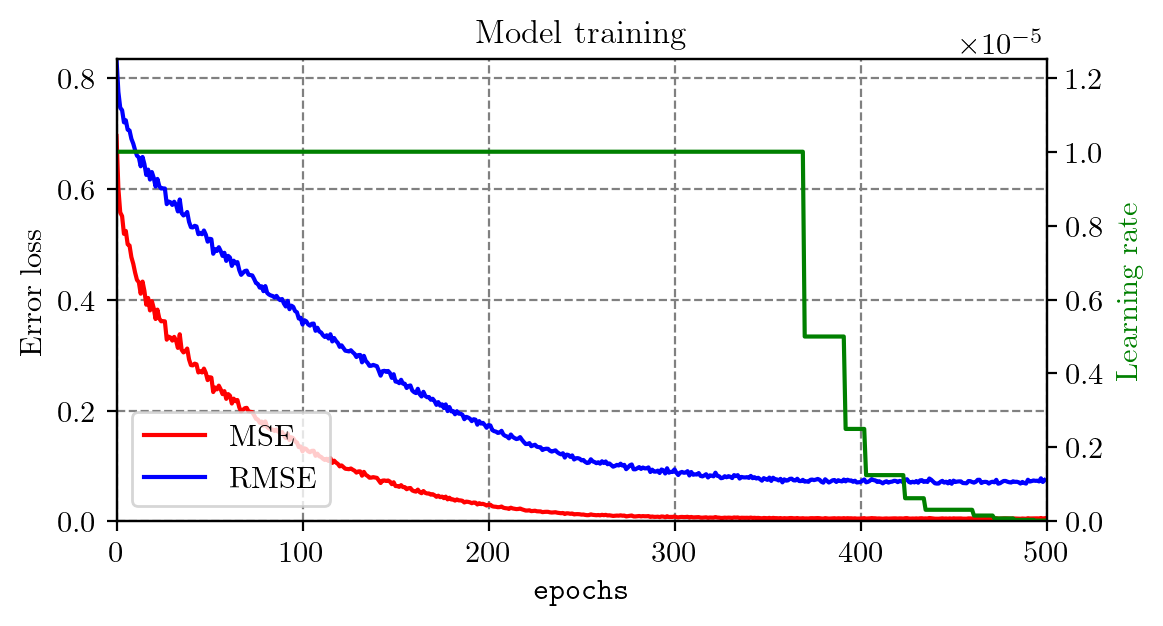

In [13]:
fig, ax1 = plt.subplots(figsize=(6,3))
plt.title(r'Model training', fontsize=12)
ax2 = ax1.twinx()
ax1.set_xlim(0, epochs)
ax1.set_ylim(0,max(np.max(losses),np.sqrt(np.max(losses))))
ax2.set_ylim(0,np.max(lr)*1.25)
ax1.plot(range(0,epochs), losses, 'r-', label=r'MSE')
ax1.plot(range(0,epochs), np.sqrt(losses), 'b-', label=r'RMSE')
ax2.plot(range(0,epochs), lr, 'g-', label=r'Learning rate')

ax1.set_xlabel(r'\texttt{epochs}')
ax1.set_ylabel(r'Error loss')
ax2.set_ylabel(r'Learning rate', color='g')
ax1.grid(True, linestyle='--', c='grey')
ax1.legend(loc='lower left')
plt.show()




In [14]:
model.init_hidden(inputs_test[:1].size(0))
forecast_val = model(inputs_test[:1])
print(features)
print(inputs_test[0])
print(forecast_val[0])
print(outputs_test[0])

# Evaluate entire dataset
with torch.no_grad():

    model.init_hidden(inputs_test.size(0))
    forecast_val = model(inputs_test)
    loss = criterion(forecast_val, outputs_test)
print(f'MSE loss on test dataset: {loss:.8f}')

['t_cd_area_over_mass', 't_cr_area_over_mass', 'c_cd_area_over_mass', 'c_cr_area_over_mass']
tensor([[0.1924, 0.0000, 0.0005, 0.0000],
        [0.1961, 0.0000, 0.0007, 0.0000],
        [0.1980, 0.0000, 0.0009, 0.0000],
        [0.1919, 0.0000, 0.0010, 0.0000],
        [0.1943, 0.0000, 0.0009, 0.0000]])
tensor([ 1.9661e-01,  1.9821e-02,  7.9015e-04, -1.4404e-04],
       grad_fn=<SelectBackward0>)
tensor([0.1953, 0.0000, 0.0007, 0.0000])
MSE loss on test dataset: 0.00286999


# Tests

#### RNN with a single LSTM-Linear layer.

In [ ]:
# Define Multivariate LSTM network class
class EventPropagation(nn.Module):
    def __init__(self,input_size, hidden_size, output_size, seq_length, num_layers=1):
        super(EventPropagation, self).__init__()
        self.input_size = input_size    # Number of input features
        self.hidden_size = hidden_size  # Number of hidden neurons
        self.output_size = output_size  # Number of outputs
        self.num_layers = num_layers    # Number of recurrent (stacked) layers
        self.seq_length = seq_length
    
        self.lstm = nn.LSTM(input_size = self.input_size, 
                            hidden_size = self.hidden_size,
                            num_layers = self.num_layers,
                            batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.linear = nn.Linear(self.hidden_size*self.seq_length, 
                                self.output_size)
    
    
    def forward(self, inputs):        
        batch_size, seq_length, input_size = inputs.size()
        
        lstm_out, lstm_states = self.lstm(inputs)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        inputs = lstm_out.contiguous().view(input_size,-1)
        outputs = self.linear(inputs)
        
        return outputs

In [ ]:
# Instanciate model with required inputs.
torch.manual_seed(42)
model = rnn.EventPropagation(input_size = len(features), 
                         hidden_size = 100,
                         output_size = len(features),
                         seq_length = seq_length)

# Define criterion, optimizer, and scheduler (dynamic learning rate adapter)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.1)

# Print model
print(model)

EventPropagation(
  (lstm): LSTM(4, 100, batch_first=True)
  (linear): Linear(in_features=500, out_features=4, bias=True)
)


In [ ]:
# A batch is in shape [batches, batch_size, seq_length, input_size]  
x=torch.Size([128, 30, 12, 45])
y=torch.Size([128, 30, 1, 1])

class MockupModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.ModuleDict({
            'lstm': nn.LSTM(
                input_size=x_features,    # 45, see the data definition
                hidden_size=hidden_size,  # Can vary
            ),
            'linear': nn.Linear(
                in_features=hidden_size,
                out_features=1)
        })

    def forward(self, x):

        # From [batches, batch_size, seq_length, input_size]
        # to [seq_length, batch_size, input_size]
        x = x.view(x_seq_len, -1, x_features)
       
        # Data is fed to the LSTM
        out, _ = self.model['lstm'](x)
        print(f'lstm output={out.size()}')

        # From [seq len, batch, num_directions * hidden_size]
        # to [batches, seqs, seq_len,prediction]
        out = out.view(x_batches, x_seqs, x_seq_len, -1)
        print(f'transformed output={out.size()}')

        # Data is fed to the Linear layer
        out = self.model['linear'](out)
        print(f'linear output={out.size()}')

        # The prediction utilizing the whole sequence is the last one
        y_pred = out[:, :, -1].unsqueeze(-1)
        print(f'y_pred={y_pred.size()}')

        return y_pred